In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import keras
import os
import cv2

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Activation, Flatten, Reshape, Dropout, UpSampling2D, MaxPooling2D, BatchNormalization, Concatenate, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Conv2D, UpSampling2D, BatchNormalization, concatenate, Flatten
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Conv2D, UpSampling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import cv2
import os 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import random

2023-12-16 09:59:21.304958: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-16 09:59:21.321629: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-16 09:59:21.321647: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-16 09:59:21.321658: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-16 09:59:21.325513: I tensorflow/core/platform/cpu_feature_g

In [2]:
from utils import *

In [3]:
# directory paths 
train_path = 'wm-nowm/train' # training directory
valid_path = 'wm-nowm/train' # validation directory

In [4]:
# Sort the watermarked and non watermarked images into parallel arrays so NN will use it better

train_path_watermarked_images = 'wm-nowm/train/watermark/'
train_path_nonwatermarked_images = 'wm-nowm/train/no-watermark/'
tp_watermarked_sorted, tp_nonwatermarked_sorted = get_data(train_path_watermarked_images, train_path_nonwatermarked_images)

In [5]:
valid_path_watermarked_images = 'wm-nowm/valid/watermark/'
valid_path_nonwatermarked_images = 'wm-nowm/valid/no-watermark/'
vp_watermarked_sorted, vp_nonwatermarked_sorted = get_data(valid_path_watermarked_images, valid_path_nonwatermarked_images)

In [6]:
# dimension to resize to 
width = 128 # only certain dimensions work due to UpSampling (196x196 works, 148x148 works)
height = 128
dim = (width, height) # set the dimensions

train_wms_pixVals = createPixelArr(tp_watermarked_sorted, dim)
train_nwms_pixVals = createPixelArr(tp_nonwatermarked_sorted, dim)

val_wms_pixVals = createPixelArr(vp_watermarked_sorted, dim)
val_nwms_pixVals = createPixelArr(vp_nonwatermarked_sorted, dim) # make ndarrays

In [7]:
# TODO use sklearn to split tp_wms_pixVals, tp_nwms_pixVals into training and testing sets
# use variables names: X_train, y_train, X_test, y_test
# 80% training, 20% testing, amount of shuffling applied
X_train, X_test, y_train, y_test = train_test_split(train_wms_pixVals, train_nwms_pixVals, train_size=0.8, random_state=1) 

In [8]:
train_wms_pixVals = 0 
train_nwms_pixVals = 0 
val_wms_pixVals = 0 
val_nwms_pixVals = 0 

In [9]:
#apply data augmentation to the X_train and y_train

data_augmented_X = [] 
data_augmented_y = []

for image in X_train:
    data_augmented_X.append(data_augmentation(image))
    
for image in y_train:
    data_augmented_y.append(data_augmentation(image))

2023-12-16 09:59:59.962435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 10:00:00.110843: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 10:00:00.110870: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 10:00:00.112459: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 10:00:00.112482: I tensorflow/compile

In [10]:
X_train = np.append(X_train, data_augmented_X, axis=0)
y_train = np.append(y_train, data_augmented_y, axis=0)

In [11]:
# normalize 
X_train = X_train / 255
y_train = y_train / 255
X_test = X_test / 255
y_test = y_test / 255

In [12]:
def generate_generator():
    x = Input(shape=(width, height, 3)) #196

    # downsample
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1) #98
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
    
    # middle
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    # upsample
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv5))
    up6 = BatchNormalization()(up6)
    #merge6 = keras.layers.concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)
     


    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
    up7 = BatchNormalization()(up7)
    #merge7 = keras.layers.concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)


    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
    up8 = BatchNormalization()(up8)
    #merge8 = keras.layers.concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)


    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
    up9 = BatchNormalization()(up9)
    #merge9 = keras.layers.concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)

    # output
    output = Conv2D(3, 1, activation='sigmoid')(conv9)

    return Model(inputs=x, outputs=output)

In [13]:
import keras 
from keras import layers

In [14]:
def autoencoder():
    inputs = Input(shape=(width, height, 3)) #128

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs) #
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # at this point the representation is (4, 4, 4) i.e. 64-dimensional

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded) #32
    x = layers.UpSampling2D((2, 2))(x) #64
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x) #62
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu',padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)


    return Model(inputs=inputs, outputs=decoded)

## image original a imagen original

In [15]:
modelo_2 = autoencoder()

modelo_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856 

In [16]:
def plot_losses(history):
    plt.rcParams['figure.figsize'] = [20, 5]
    # Create a single subplot
    fig, ax1 = plt.subplots()


    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax1.grid()


    ax1.plot(history['g_loss'], label='G loss')
    ax1.legend()


    plt.show()


In [17]:
def train(X_train, y_train, modelo, epochs, batch_size=32):

    history = {
        'g_loss' : []
    }

    for epoch in range(epochs):
        print("----EPOCH " + str(epoch) + '-----')
        for batch in range(int(len(X_train)/batch_size)):

            #  Train the Discriminator
            train_img = X_train[batch*batch_size : (batch+1)*batch_size]
            gen_imgs = modelo.predict(train_img, verbose=0)
            test_img = y_train[batch*batch_size : (batch+1)*batch_size]

            # Train the Generator
            # Añadir como entrada y salida las etiquetas generadas
            g_loss = modelo.train_on_batch(gen_imgs,  test_img)

            # Save losses
            history['g_loss'].append(g_loss)

            # Plot the progress
            if batch % 50 == 0:
                print ("%d [G loss: %.4f]" % (batch, g_loss[0]))

            if batch % 500 == 0:
                sample_images(epoch, batch, gen_imgs, test_img) # TODO CAMBIAR ESTO POR LAS VARIABLES NUESTRAS

        plot_losses(history)

In [18]:
def sample_images(epoch, batch, gen_imgs, imgs):
    plt.rcParams['figure.figsize'] = [15, 5]
    fig, axs = plt.subplots(2, 5)
    fig.suptitle('Epoch: ' + str(epoch) + ', Batch: ' + str(batch), fontsize=16)
    for i in range(5):
        
        axs[0,i].imshow(gen_imgs[i][:,:,::-1])
        axs[0,i].axis('off')

    for i in range(5):
        axs[1,i].imshow(imgs[i][:,:,::-1])
        axs[1,i].axis('off')
    plt.show()
    plt.close()

In [19]:
modelo_2.compile(optimizer='adam', loss='mse', metrics=['mse'])


In [20]:
history= modelo_2.fit(y_train, y_train, epochs=200, batch_size=128, validation_data=(y_test, y_test))

Epoch 1/200


2023-12-16 10:00:10.051997: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2023-12-16 10:00:10.237623: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-16 10:00:11.167046: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-16 10:00:12.125849: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fdd4a260710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-16 10:00:12.125886: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2023-12-16 10:00:12.131445: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-16 10:00:12.203178: I ./tensorflow/compiler/jit/device_c

22/22 [==============================] - 8s 166ms/step - loss: 0.0446 - mse: 0.0446 - val_loss: 0.0286 - val_mse: 0.0286
Epoch 2/200
22/22 [==============================] - 1s 55ms/step - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0161 - val_mse: 0.0161
Epoch 3/200
22/22 [==============================] - 1s 55ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0246 - val_mse: 0.0246
Epoch 4/200
22/22 [==============================] - 1s 55ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0154 - val_mse: 0.0154
Epoch 5/200
22/22 [==============================] - 1s 55ms/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 6/200
22/22 [==============================] - 1s 55ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 7/200
22/22 [==============================] - 1s 55ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 8/200
22/22 [==============================] - 1s 55ms/step - loss: 0.0061 - mse:

11/11 [==============================] - 0s 14ms/step


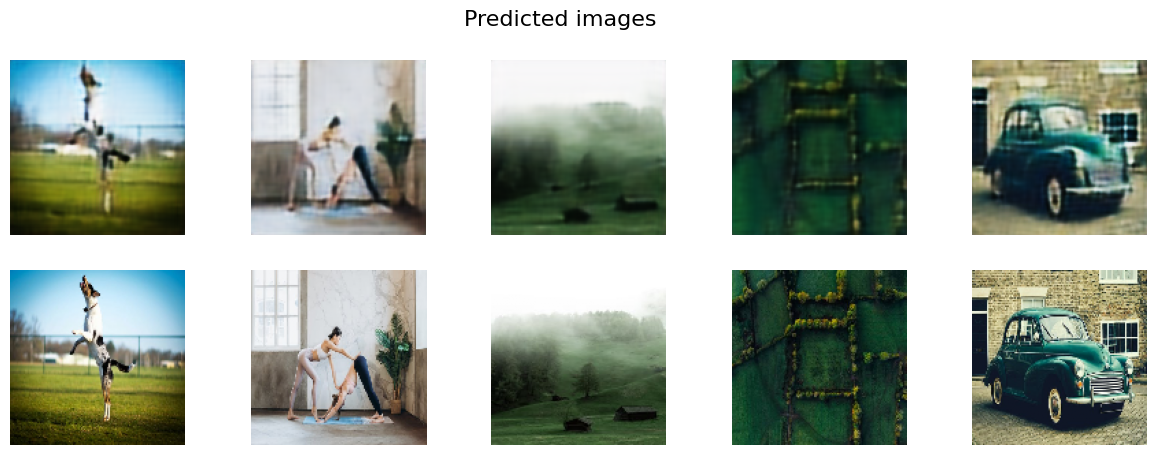

In [21]:
# show predict images
y_pred = modelo_2.predict(y_test)

plt.rcParams['figure.figsize'] = [15, 5]
fig, axs = plt.subplots(2, 5)
fig.suptitle('Predicted images', fontsize=16)
for i in range(5):
    axs[0,i].imshow(y_pred[i][:,:,::-1])
    axs[0,i].axis('off')

for i in range(5):
    axs[1,i].imshow(y_test[i][:,:,::-1])
    axs[1,i].axis('off')
plt.show()
plt.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


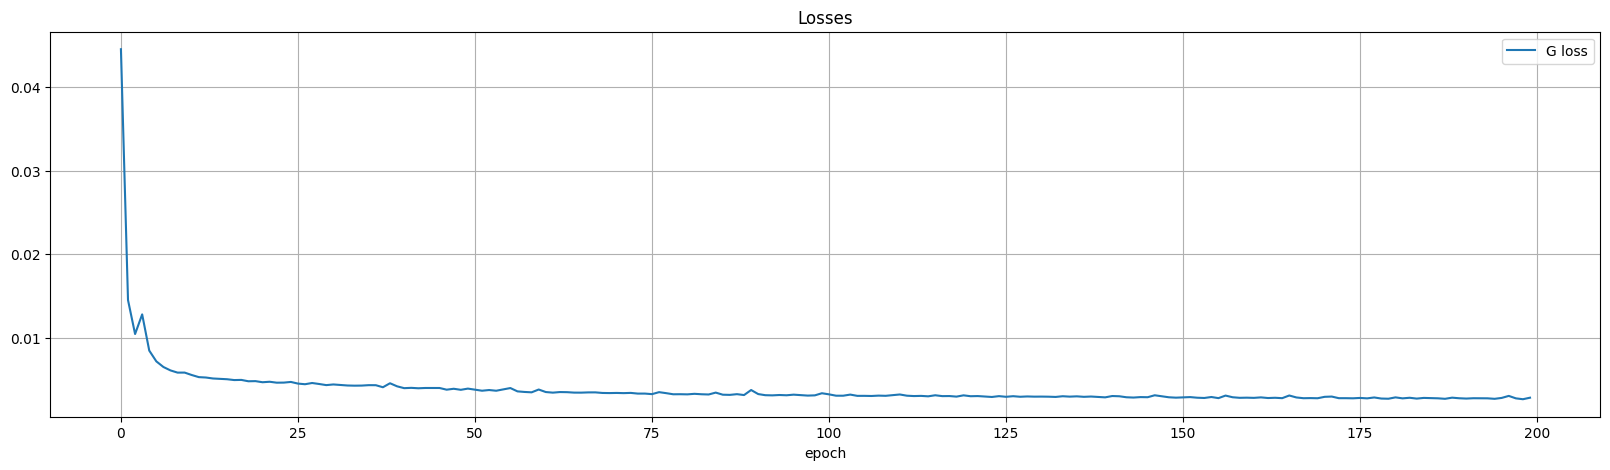

In [22]:
# plot losses with plt
plt.rcParams['figure.figsize'] = [20, 5]
# Create a single subplot
fig, ax1 = plt.subplots()


ax1.set_title('Losses')
ax1.set_xlabel('epoch')
ax1.legend(loc="upper right")
ax1.grid()


ax1.plot(history.history['loss'], label='G loss')
ax1.legend()
plt.show()


## marca de agua a marca de agua

In [23]:
modelo_3 = autoencoder()

modelo_3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 128)       7385

In [24]:
modelo_3.compile(optimizer='adam', loss='mse', metrics=['mse'])


In [25]:
history= modelo_3.fit(X_train, X_train, epochs=200, batch_size=128, validation_data=(X_test, X_test))

Epoch 1/200
22/22 [==============================] - 2s 65ms/step - loss: 0.0467 - mse: 0.0467 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 2/200
22/22 [==============================] - 1s 55ms/step - loss: 0.0183 - mse: 0.0183 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 3/200
22/22 [==============================] - 1s 54ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0148 - val_mse: 0.0148
Epoch 4/200
22/22 [==============================] - 1s 54ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 5/200
22/22 [==============================] - 1s 54ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 6/200
22/22 [==============================] - 1s 54ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 7/200
22/22 [==============================] - 1s 54ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 8/200
22/22 [==============================] - 1s 53ms/step - loss: 0.

11/11 [==============================] - 0s 4ms/step


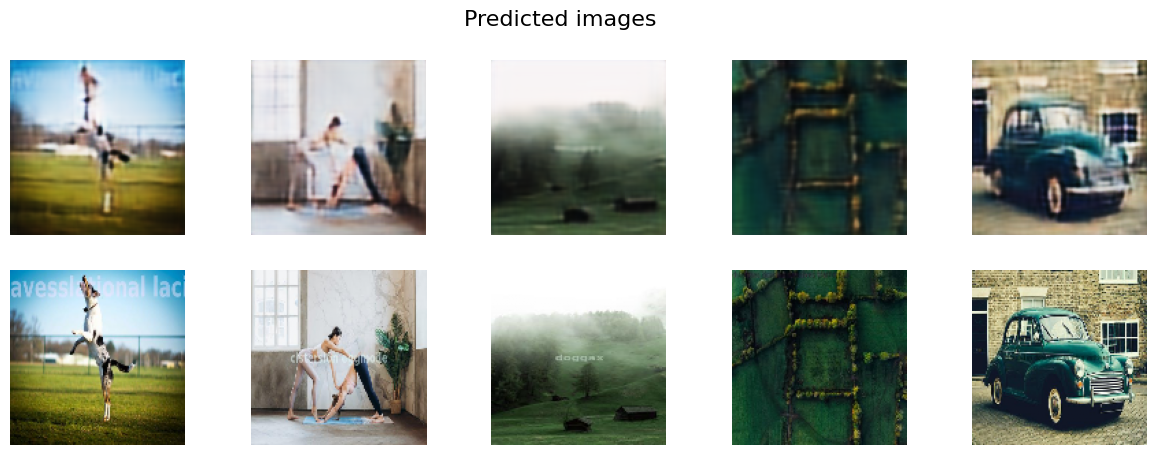

In [26]:
# show predict images
y_pred = modelo_3.predict(X_test)

plt.rcParams['figure.figsize'] = [15, 5]
fig, axs = plt.subplots(2, 5)
fig.suptitle('Predicted images', fontsize=16)
for i in range(5):
    axs[0,i].imshow(y_pred[i][:,:,::-1])
    axs[0,i].axis('off')

for i in range(5):
    axs[1,i].imshow(X_test[i][:,:,::-1])
    axs[1,i].axis('off')
plt.show()
plt.close()

In [27]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


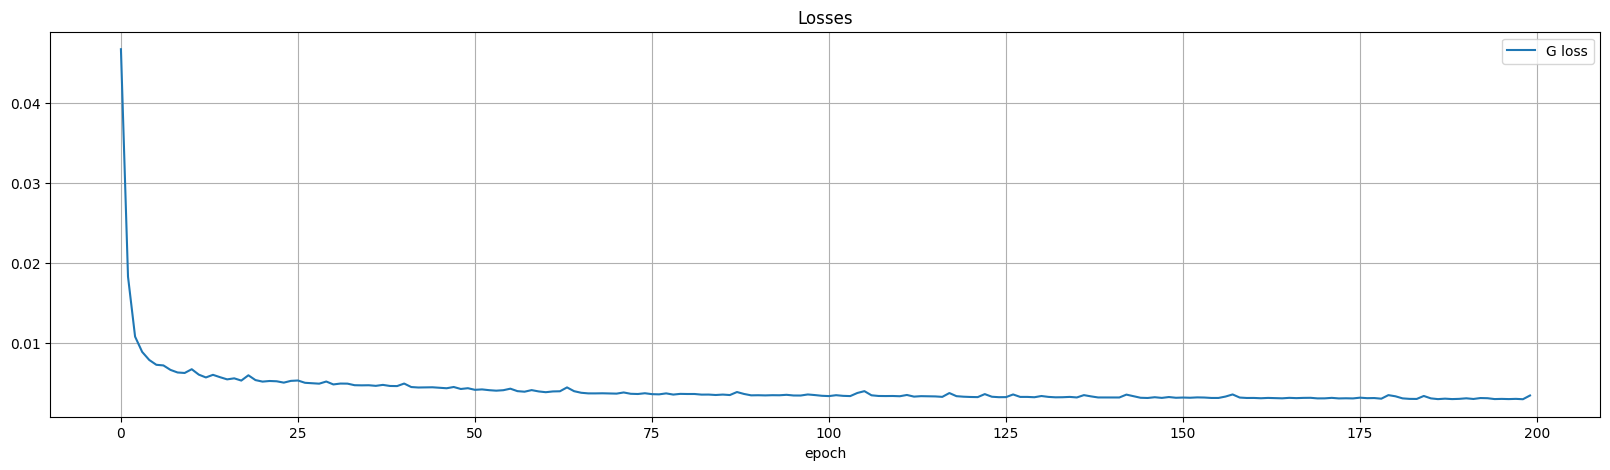

In [28]:
# plot  val losses with plt
plt.rcParams['figure.figsize'] = [20, 5]
# Create a single subplot
fig, ax1 = plt.subplots()


ax1.set_title('Losses')
ax1.set_xlabel('epoch')
ax1.legend(loc="upper right")
ax1.grid()


ax1.plot(history.history['loss'], label='G loss')
ax1.legend()



plt.show()


## parche a imagen original

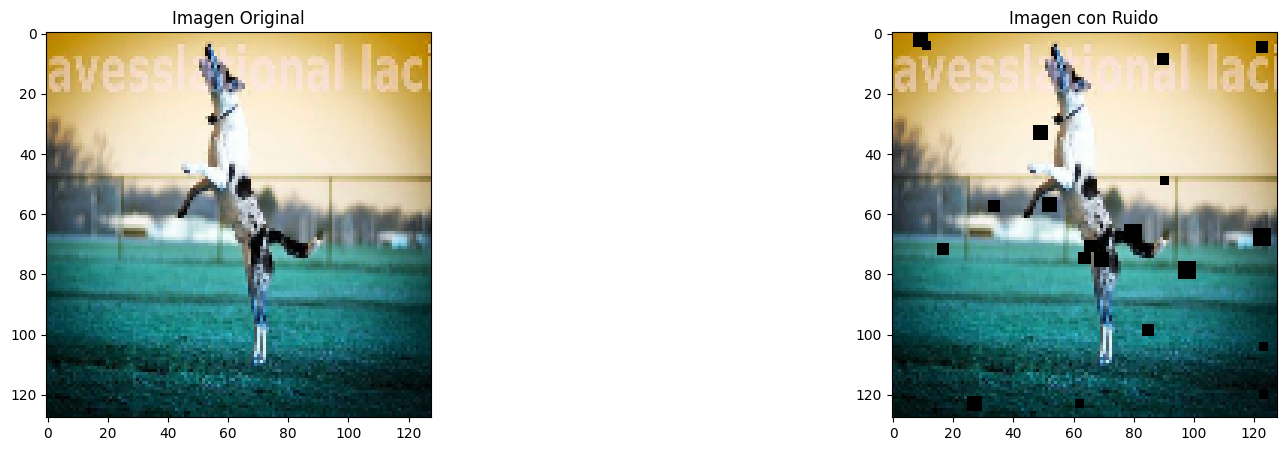

In [29]:
import numpy as np
import matplotlib.pyplot as plt


# Función para añadir parches de ruido a la imagen
def agregar_parches_de_ruido(imagen, cantidad_parches=100, tamaño_max=20):
    imagen_con_ruido = np.copy(imagen)
    
    alto, ancho, _ = imagen.shape
    
    for _ in range(cantidad_parches):
        # Generar coordenadas aleatorias para el parche
                
        tamaño_parche = np.random.randint(3, tamaño_max)
        y = np.random.randint(0, alto - tamaño_parche)
        x = np.random.randint(0, ancho - tamaño_parche)

        
        # Superponer el parche de ruido en la imagen
        imagen_con_ruido[y:y+tamaño_parche, x:x+tamaño_parche, :] = 0
        
        
        # Asegurarse de que los valores estén en el rango [0, 255]
        imagen_con_ruido = np.clip(imagen_con_ruido, 0, 255)
    
    return imagen_con_ruido

# Añadir parches de ruido a la imagen
imagen_con_ruido = agregar_parches_de_ruido(X_test[0], cantidad_parches=20, tamaño_max=7)

# Mostrar la imagen original y la imagen con ruido
plt.subplot(1, 2, 1)
plt.imshow(X_test[0])
plt.title('Imagen Original')

plt.subplot(1, 2, 2)
plt.imshow(imagen_con_ruido)
plt.title('Imagen con Ruido')

plt.show()

In [30]:
# transform train and test images into noisy images
y_train_noise = []
y_test_noise = []

for image in y_train:
    y_train_noise.append(agregar_parches_de_ruido(image, cantidad_parches=20, tamaño_max=7))

for image in X_test:
    y_test_noise.append(agregar_parches_de_ruido(image, cantidad_parches=20, tamaño_max=7))

y_train_noise = np.array(y_train_noise)

y_test_noise = np.array(y_test_noise)

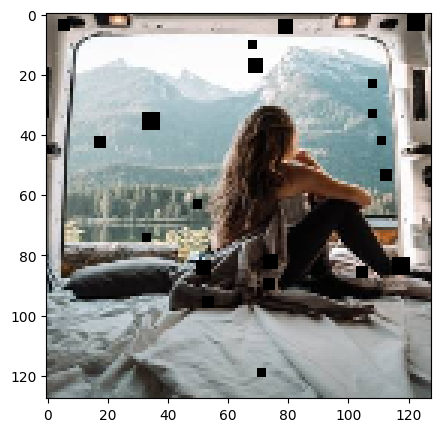

In [35]:
plt.imshow(y_train_noise[0][:, :, ::-1])

In [38]:
# create directories to save images
os.mkdir('wm-nowm/train/noisy')
os.mkdir('wm-nowm/valid/noisy')

# save the noisy images
for i in range(len(y_train_noise)):
    cv2.imwrite('wm-nowm/train/noisy/' + str(i) + '.jpg', y_train_noise[i]*255)

for i in range(len(y_test_noise)):
    cv2.imwrite('wm-nowm/valid/noisy/' + str(i) + '.jpg', y_test_noise[i]*255)




In [39]:
def unet():
    inputs = Input(shape=(width, height, 3)) #128

    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs) #
    conv1 = layers.MaxPooling2D((2, 2), padding='same')(conv1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv2 = layers.MaxPooling2D((2, 2), padding='same')(conv2)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    
    encoded = layers.MaxPooling2D((2, 2), padding='same')(conv3)

    # at this point the representation is (4, 4, 4) i.e. 64-dimensional

    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded) #32
    conv4 = layers.UpSampling2D((2, 2))(conv4) #64
    merge4 = keras.layers.concatenate([conv2, conv3], axis=3)
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge4) #62
    conv5 = layers.UpSampling2D((2, 2))(conv5)
    merge5 = keras.layers.concatenate([conv1, conv5], axis=3)
    conv6 = layers.Conv2D(32, (3, 3), activation='relu',padding='same')(merge5)
    conv6 = layers.UpSampling2D((2, 2))(conv6)
    merge6 = keras.layers.concatenate([inputs, conv6], axis=3)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(merge6)


    return Model(inputs=inputs, outputs=decoded)

In [40]:
# get the noisy images
train_path_noisy_images = 'wm-nowm/train/noisy/'
train_path_nonnoisy_images = 'wm-nowm/train/no-watermark/'

tp_noisy_sorted, tp_nonnoisy_sorted = get_data(train_path_noisy_images, train_path_nonnoisy_images)

valid_path_noisy_images = 'wm-nowm/valid/noisy/'
valid_path_nonnoisy_images = 'wm-nowm/valid/no-watermark/'

vp_noisy_sorted, vp_nonnoisy_sorted = get_data(valid_path_noisy_images, valid_path_nonnoisy_images)

train_noisy_pixVals = createPixelArr(tp_noisy_sorted, dim)
train_nonnoisy_pixVals = createPixelArr(tp_nonnoisy_sorted, dim)

val_noisy_pixVals = createPixelArr(vp_noisy_sorted, dim)
val_nonnoisy_pixVals = createPixelArr(vp_nonnoisy_sorted, dim) # make ndarrays

# TODO use sklearn to split tp_wms_pixVals, tp_nwms_pixVals into training and testing sets
# use variables names: X_train, y_train, X_test, y_test
# 80% training, 20% testing, amount of shuffling applied
X_train, X_test, y_train, y_test = train_test_split(train_noisy_pixVals, train_nonnoisy_pixVals, train_size=0.8, random_state=1)

ValueError: With n_samples=0, test_size=None and train_size=0.8, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
modelo_4 = autoencoder()

modelo_4.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 128)       7385

In [ ]:
modelo_4.compile(optimizer='adam', loss='mse', metrics=['mse'])


In [ ]:
history= modelo_4.fit(y_train_noise, y_train, epochs=200, batch_size=128, validation_data=(y_test_noise, y_test))

: 

11/11 [==============================] - 0s 4ms/step


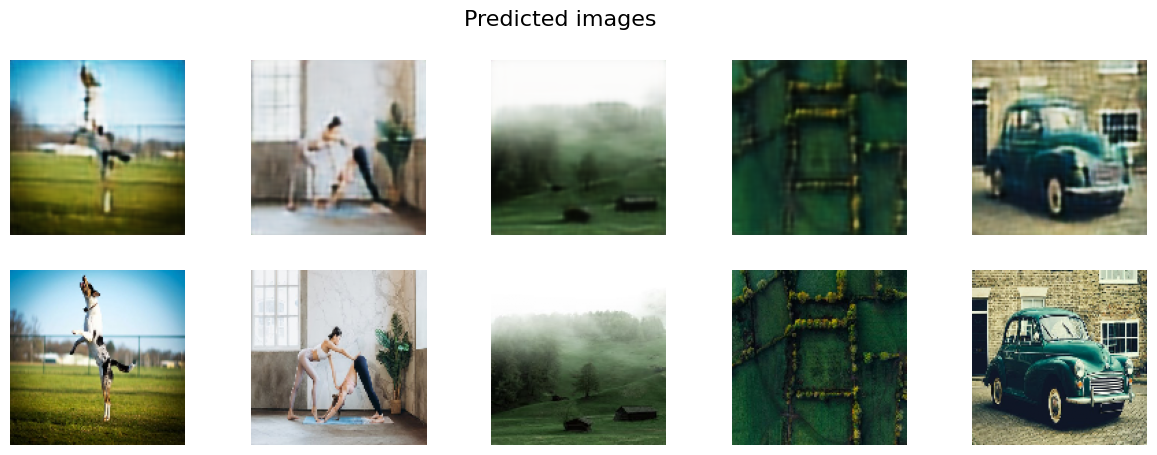

In [ ]:
# show predict images
y_pred = modelo_4.predict(y_test)
 
plt.rcParams['figure.figsize'] = [15, 5]
fig, axs = plt.subplots(2, 5)
fig.suptitle('Predicted images', fontsize=16)
for i in range(5):
    axs[0,i].imshow(y_pred[i][:,:,::-1])
    axs[0,i].axis('off')

for i in range(5):
    axs[1,i].imshow(y_test[i][:,:,::-1])
    axs[1,i].axis('off')
plt.show()
plt.close()

In [ ]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


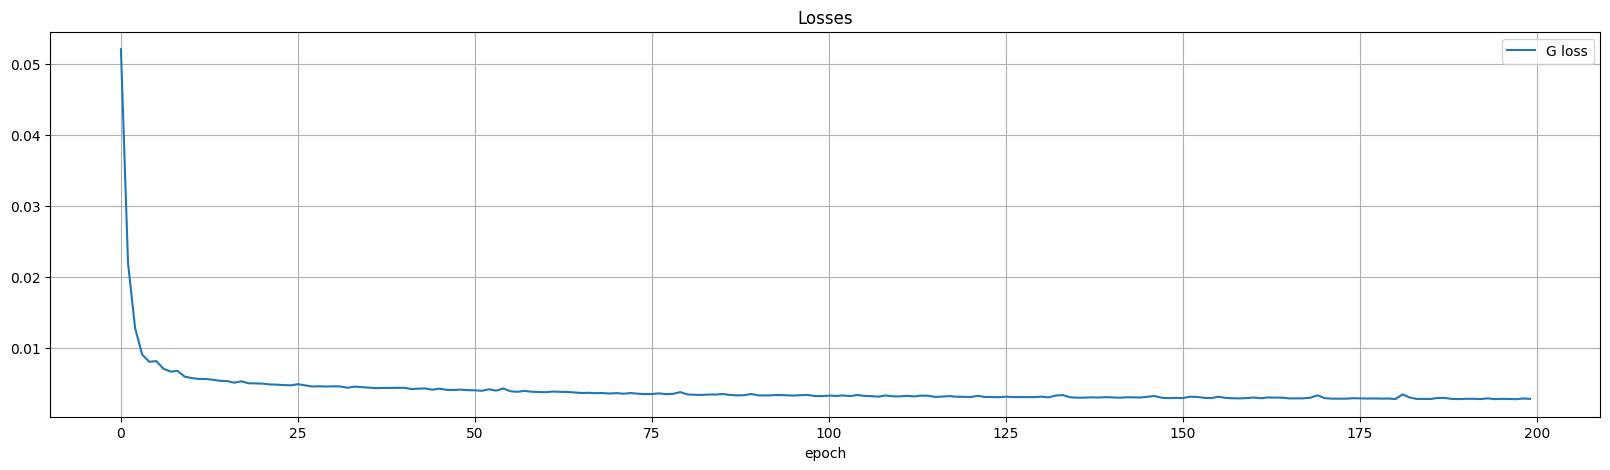

In [ ]:
# plot  val losses with plt
plt.rcParams['figure.figsize'] = [20, 5]
# Create a single subplot
fig, ax1 = plt.subplots()


ax1.set_title('Losses')
ax1.set_xlabel('epoch')
ax1.legend(loc="upper right")
ax1.grid()


ax1.plot(history.history['loss'], label='G loss')
ax1.legend()



plt.show()
